In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
plt.style.use('bmh')

os.chdir('/project/lcd_v2/')

In [4]:
df = pd.read_csv('.cache/sim_data/transistors.csv')
df.loc[df['gate']==1129]

bb   c1    c2  gate   name     on       x       y  \
362   [6654, 6672, 9206, 9376]  657   943  1129   t362  False  6663.0  9291.0   
1999  [6754, 6771, 9103, 9652]  558  1467  1129  t1999  False  6762.5  9377.5   

       pos  
362    362  
1999  1999

In [5]:
df = pd.read_csv('.cache/sim_data/wires.csv')
df.loc[df['name']=='cclk']


wireid  c1c2s  gates  pullup  name
932     943      6    273   False  cclk

In [6]:
# get transistor meta-data
!cd .cache/sim_data && wget -N https://s3-us-west-2.amazonaws.com/ericmjonas-public/data/neuroproc/transistors.csv
!cd .cache/sim_data && wget -N https://s3-us-west-2.amazonaws.com/ericmjonas-public/data/neuroproc/wires.csv

--2023-05-25 06:57:14--  https://s3-us-west-2.amazonaws.com/ericmjonas-public/data/neuroproc/transistors.csv
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.218.0, 52.92.132.176, 52.92.128.232, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.218.0|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘transistors.csv’ not modified on server. Omitting download.

--2023-05-25 06:57:14--  https://s3-us-west-2.amazonaws.com/ericmjonas-public/data/neuroproc/wires.csv
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.128.232, 3.5.80.142, 52.92.130.136, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.128.232|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘wires.csv’ not modified on server. Omitting download.



In [7]:
interval = 10
step_limit = 30
num_iterations = 128
window = '896_1024'
root_dir = '.cache/sim_data'

In [8]:
# helper functions
def get_cmap_slice(cmap, start, stop, n=256, name='my_slice'):
    return colors.LinearSegmentedColormap.from_list(name, cmap(np.linspace(start, stop, cmap.N)),N=n)

def get_perturb_config(window):
    # perturb at the middle of the interation_time
    perturb_timepoint = num_iterations // 2
    current_voltages = window[:, step_limit * perturb_timepoint]
    # 0: 'low', 1: 'high'
    perturb_types = np.where(current_voltages == 1, 0, 1)
    perturb_config = {tidx: (perturb_timepoint, perturb_types[tidx]) for tidx in range(len(current_voltages))
                      if window[tidx].std() != 0}
    return perturb_config

# get geometry information of transistors
ts_info = pd.read_csv(os.path.join(os.path.dirname(root_dir), 'transistors.csv'))

def get_strength(kwargs):
    idx, game = kwargs['idx'], kwargs['game']
    if isinstance(idx, int):
        orig = np.load(os.path.join(root_dir, f'{game}/HR/window_{window}/Regular_3510_step_{num_iterations}_rec_{step_limit}_window_{window}.npy'), mmap_mode='r')
        potential_resultant = []
        unique_perturb = get_perturb_config(orig)
        perturb = np.load(os.path.join(root_dir, f"{game}/HR/window_{window}/Perturb_3510_step_{window.split('_')[-1]}_tidx_{idx}.npy"), mmap_mode='r')
        print(idx, perturb.shape, orig[idx].std())
        # padding to the fix length of one half-clock, last point is marker (-1)
        if perturb.shape[1] > step_limit:
            padded_perturb = perturb[:, :step_limit]
        else:
            padded_perturb = np.concatenate(
                (perturb[:, :-1], np.tile(perturb[:, -2].reshape(-1, 1), step_limit - perturb.shape[1] + 1)),
                axis=1)

        perturb_timepoint = unique_perturb[idx][0]
        for i in range(3510):
            # compare the regular state and 'perturbed' state when the cause transistor (idx) is perturbed
            # skip the cause transistor itself and the transistor has constant value
            if orig[i].std() != 0 and i != idx:
                # detect the first point where the perturbation actually works
                causal_effect = np.abs((padded_perturb[i] - orig[i, perturb_timepoint*step_limit:(perturb_timepoint+1)*step_limit])).mean()
                potential_resultant.append(causal_effect)
            else:
                potential_resultant.append(0)
        return potential_resultant
    else:
        assert isinstance(idx, list), 'idx must be an integer or a list of integers'
    with mp.Pool(mp.cpu_count()) as pool:
        potential_resultant = pool.map(get_strength, [{'idx': i, 'game': game} for i in idx])
        potential_resultant = iter(np.mean(potential_resultant, axis=-1).tolist())
        potential_resultant = [next(potential_resultant) if i in idx else 0 for i in range(3510)]
    return potential_resultant

def plot_cause_effect(target_idx, save_dir=None):
    games = ['DonkeyKong', 'Pitfall', 'SpaceInvaders']
    effect = {game: get_strength({'idx': target_idx, 'game': game}) for game in games}
    max_effect = np.max([_effect for t_effect in effect.values() for _effect in t_effect])
    fig, axs = plt.subplots(1, len(games), figsize=(len(games)*10, 10), sharex=True, sharey=True)
    cmap = get_cmap_slice(plt.get_cmap("Reds"), 0.2, 1.0)
    for idx, (game, _effect) in enumerate(effect.items()):
        # Normalize the causal effect
        if max_effect != 0:
            causal_effect = np.array(_effect) / max_effect
        else:
            causal_effect = np.array(_effect)
        # Heatmap of causal effect
        im = axs[idx].scatter(ts_info.x, ts_info.y, c=causal_effect, cmap=cmap, edgecolor='none', vmin=0, vmax=1)
        if not isinstance(target_idx, list) and not isinstance(target_idx, str):
            axs[idx].scatter(ts_info.x.iloc[target_idx], ts_info.y.iloc[target_idx], c='blue', s=10**2, edgecolor='none')
        axs[idx].tick_params(axis='x', labelsize=12)
        axs[idx].tick_params(axis='y', labelsize=12)
        axs[idx].set_title(game, fontdict={'family': 'Serif'}, fontsize=30)

    fig.set_facecolor('w')
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.05)
    fig.text(0.45, 0.05, "X Position (um)", fontdict={'family': 'Serif'}, size=20)
    fig.text(0.07, 0.5, "Y Position (um)", rotation='vertical', fontdict={'family': 'Serif'}, size=20)
    cbar = fig.colorbar(im, cax=plt.axes([0.82, 0.1, 0.02, 0.8]))
    cbar.set_label('Cause Effect Strength', fontdict={'family': 'Serif'}, size=20)
    cbar.set_ticks(ticks=np.arange(0.0, 1.0, 0.1))
    cbar.ax.tick_params(labelsize=10)
    fig.clim = (0.0, 1.0)
    if save_dir is not None:
        plt.savefig(f"{save_dir}.svg")

def plot_transistors(target_idx, save_dir=None):
    fig = plt.figure(figsize=(10, 10))
    # specific colors for target idx
    cls = iter(['#DE1334', '#FF414C', '#6752FF'])
    cmap = get_cmap_slice(plt.get_cmap("Reds"), 0.2, 1.0)
    c = [idx for idx in range(3510) if idx not in target_idx]
    # Heatmap of causal effect
    plt.scatter(ts_info.x[c], ts_info.y[c], c=[0]*len(c), cmap=cmap, edgecolor='none')
    for idx in target_idx:
        plt.scatter(ts_info.x[idx], ts_info.y[idx], c=next(cls), s=10**2, cmap=cmap, edgecolor='none', label=f'transistor {idx}')
    if not isinstance(target_idx, list) and not isinstance(target_idx, str):
        plt.scatter(ts_info.x.iloc[target_idx], ts_info.y.iloc[target_idx], c='blue', s=10**2, cmap=cmap, edgecolor='none')
    plt.xticks([])
    plt.yticks([])
    fig.clim = (0.0, 1.0)
    plt.legend()
    if save_dir is not None:
        plt.savefig(f"{save_dir}.svg")


In [9]:
window = '0_128'
adj = pickle.load(open(os.path.join(root_dir, f'DonkeyKong/HR/window_{window}/adjacency_matrix.pkl'), 'rb'), encoding='latin1')
# sort the dict by the length of the value
adj = {k: v for k, v in sorted(adj.items(), key=lambda item: len(item[1]), reverse=True)}
adj

{112: [3435, 1637],
 2276: [3036, 1048],
 338: [2258, 1217],
 572: [2759, 3064],
 585: [147, 246],
 1021: [244, 3025],
 1542: [2533, 3486],
 3355: [3021, 1347],
 0: [2673],
 2: [215],
 2049: [3335],
 10: [438],
 2069: [266],
 2078: [160],
 42: [1589],
 58: [1577],
 64: [1340],
 2113: [2901],
 2119: [1516],
 82: [145],
 2185: [1116],
 99: [984],
 2152: [79],
 2748: [2078],
 113: [3047],
 115: [333],
 119: [561],
 121: [384],
 124: [2249],
 131: [1612],
 2182: [1877],
 137: [1664],
 148: [2209],
 162: [3222],
 168: [58],
 169: [1202],
 183: [171],
 190: [2375],
 2256: [1526],
 2258: [2936],
 213: [1383],
 215: [270],
 217: [1983],
 239: [1348],
 240: [2152],
 245: [3194],
 246: [496],
 263: [148],
 266: [536],
 271: [134],
 272: [1803],
 2321: [1606],
 275: [2012],
 2325: [477],
 281: [1207],
 2333: [3326],
 289: [1194],
 308: [397],
 317: [2250],
 321: [932],
 396: [3491],
 337: [2154],
 340: [1021],
 363: [3437],
 365: [2609],
 2427: [129],
 384: [1775],
 387: [2114],
 2444: [131],
 40

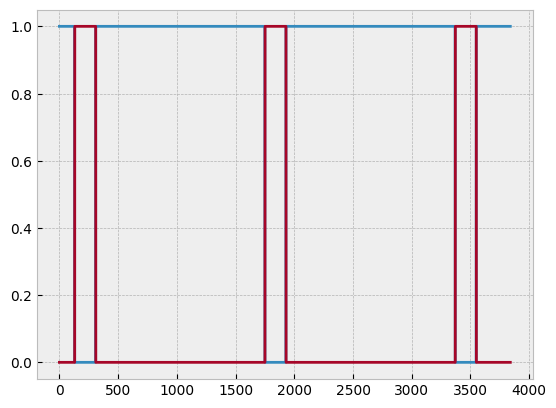

In [12]:
import matplotlib.pyplot as plt

orig = np.load(os.path.join(root_dir, f'DonkeyKong/HR/window_{window}/Regular_3510_step_{num_iterations}_rec_{step_limit}_window_{window}.npy'), mmap_mode='r')
plt.plot(orig[1207, ])
plt.plot(orig[1177, ])

452 (3510, 71) 0.49999972873256526
452 (3510, 58) 0.49999972873256526
452 (3510, 55) 0.49999972873256526


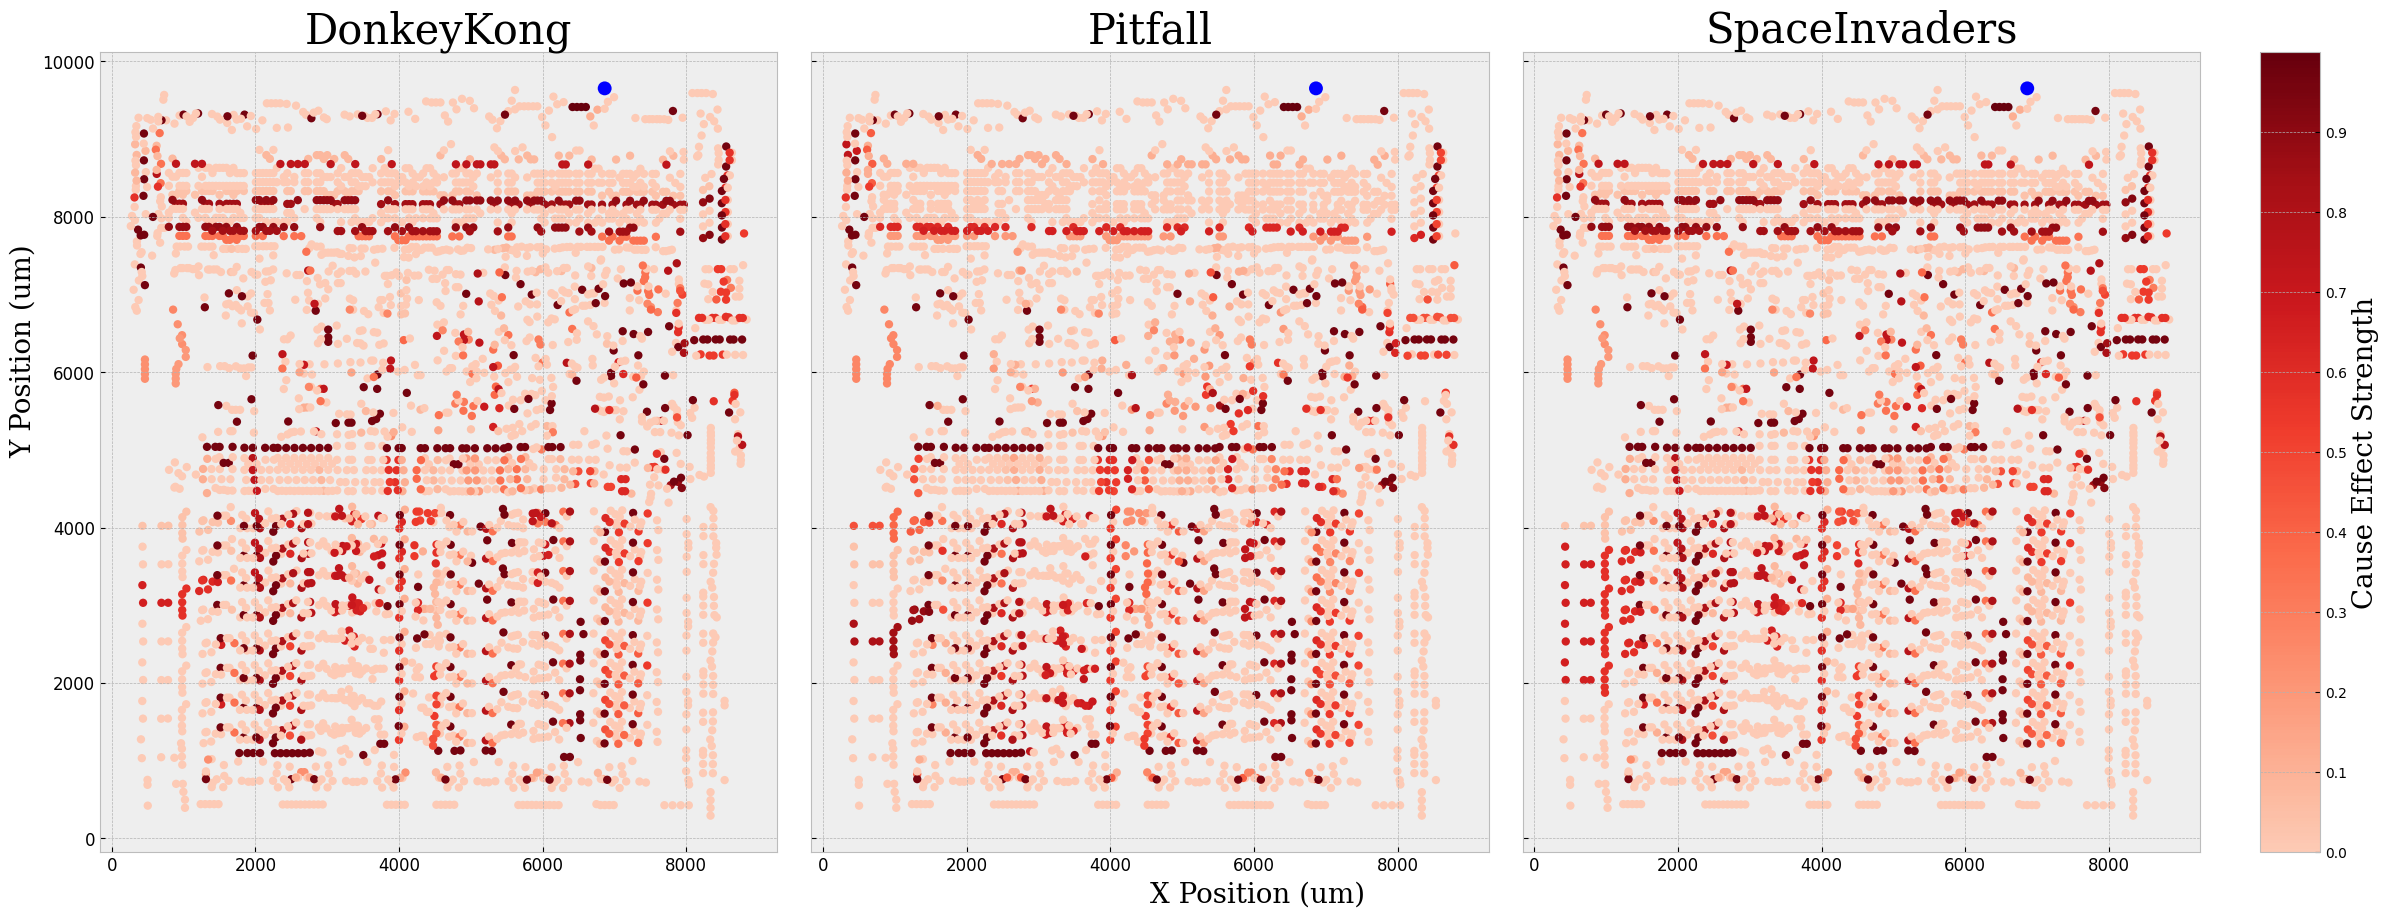

In [9]:
plot_cause_effect(target_idx=452, save_dir='/project/lcd_v2/figure/Figure 2. Causal Effect/transistor_452')

3355 (3510, 19) 0.4866935994259861
3355 (3510, 20) 0.4841229182759271
3355 (3510, 19) 0.4866935994259861


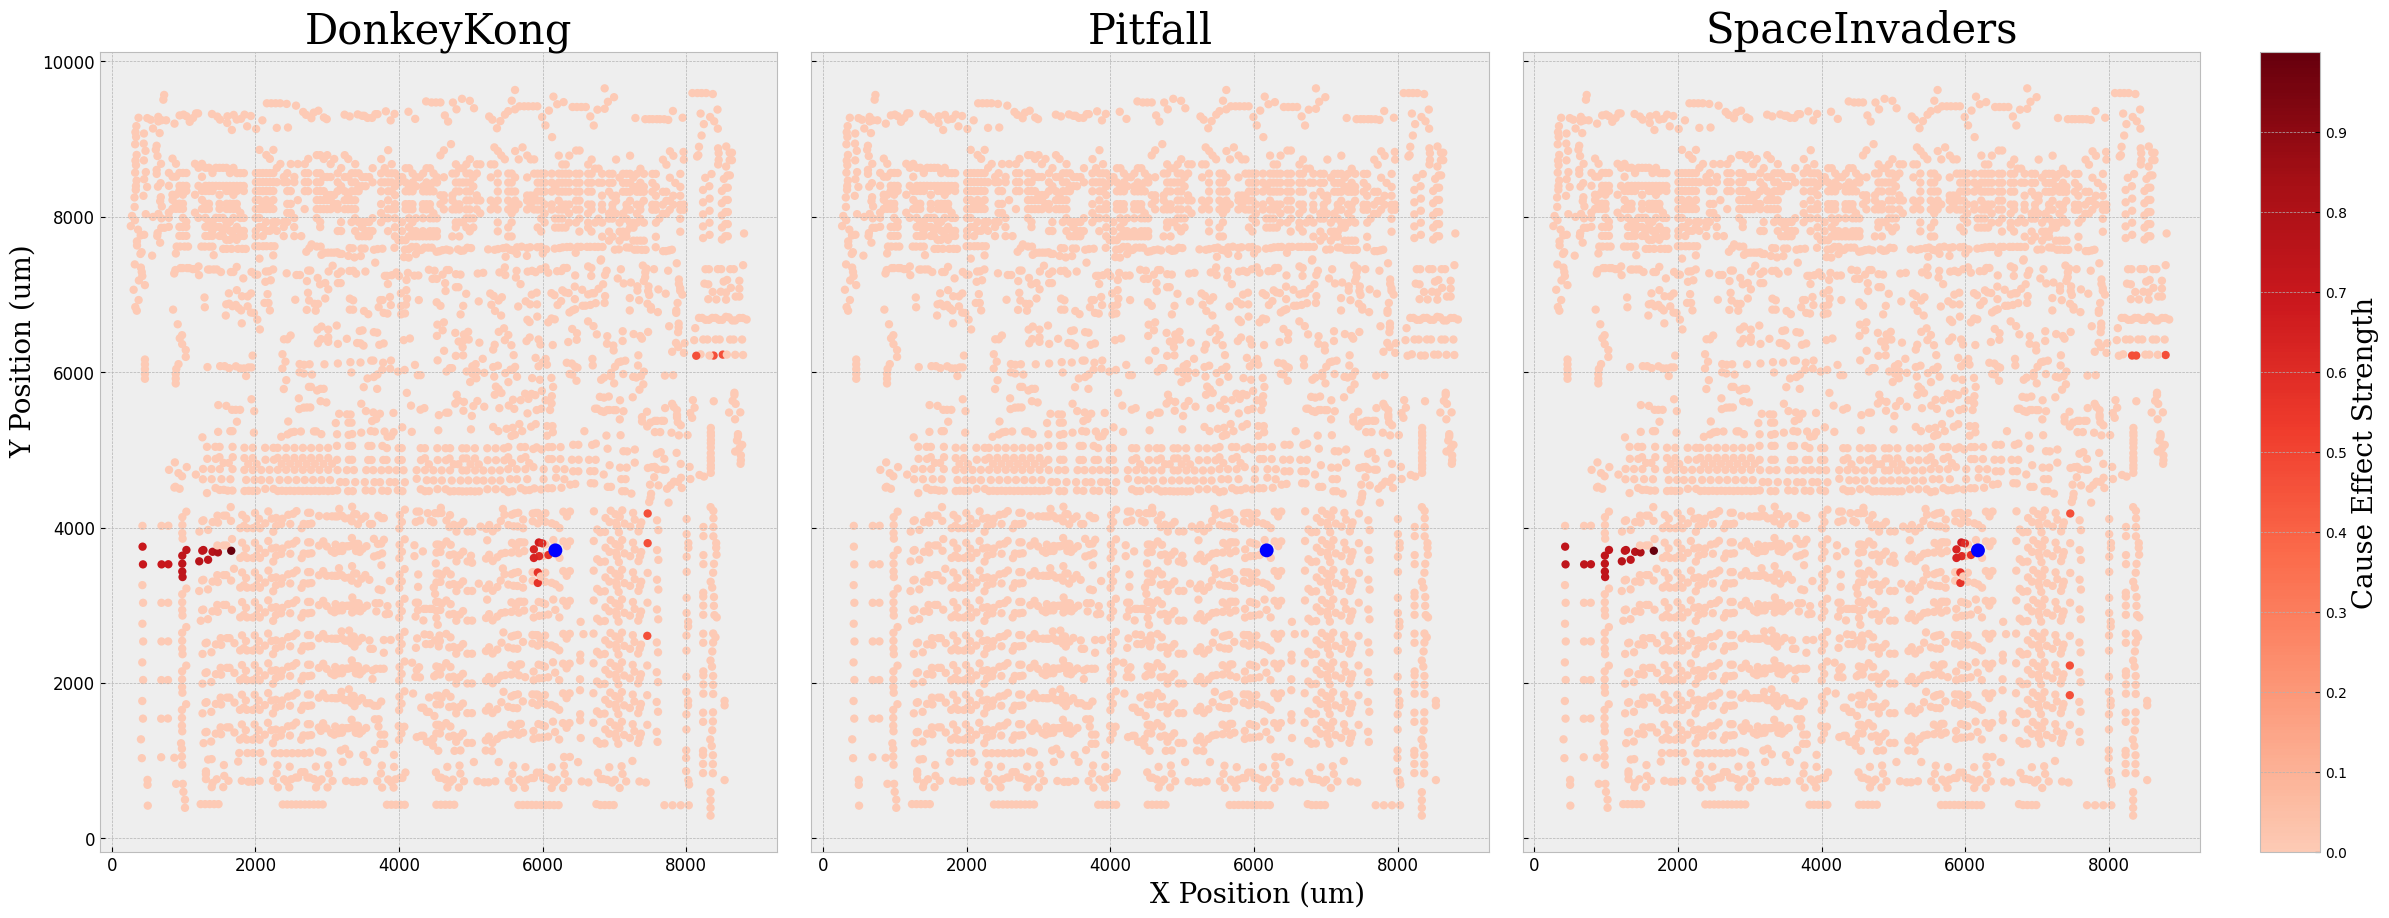

In [10]:
plot_cause_effect(target_idx=3355, save_dir='/project/lcd_v2/figure/Figure 2. Causal Effect/transistor_3355')

134 (3510, 19) 0.4923765069192195
134 (3510, 20) 0.4923765069192195
134 (3510, 19) 0.4923765069192195


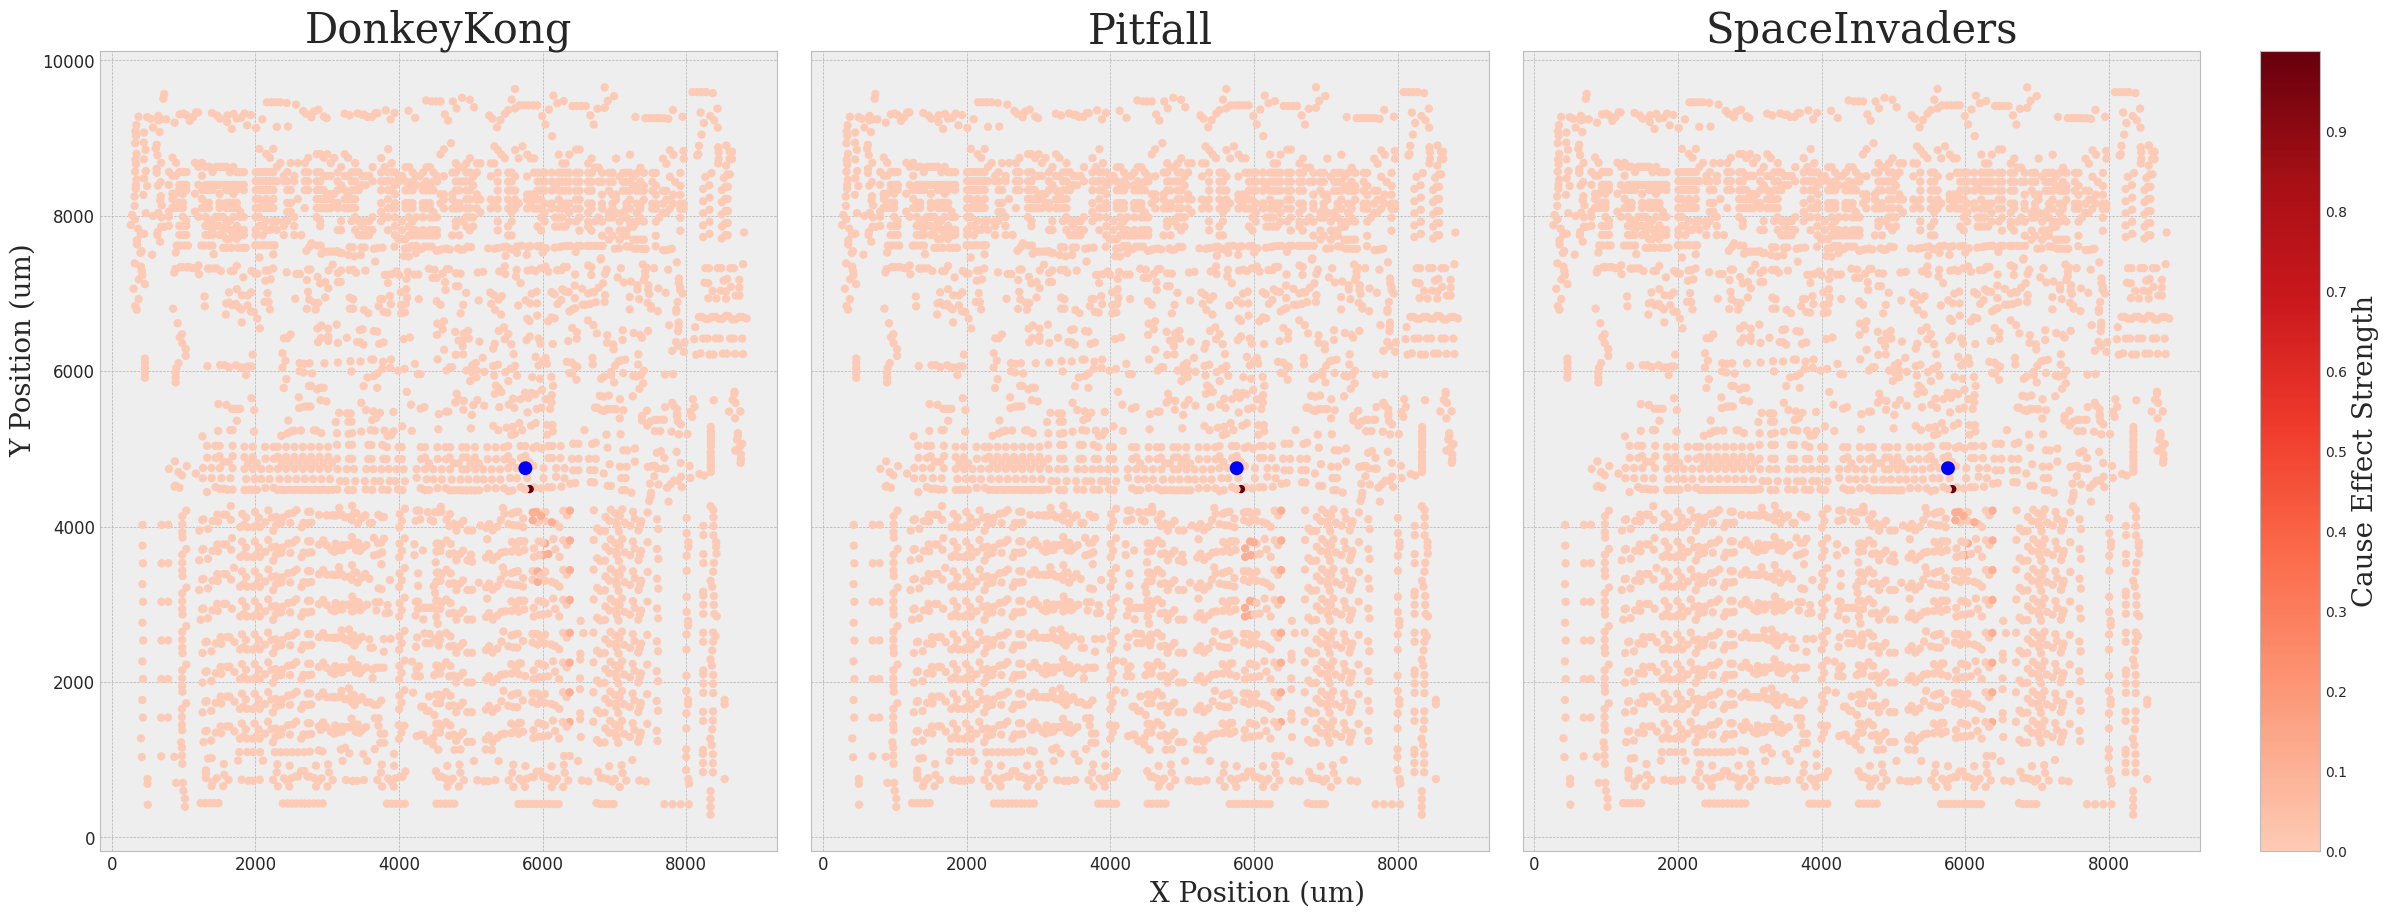

In [56]:
plot_cause_effect(target_idx=134, save_dir='/project/lcd_v2/figure/Figure 2. Causal Effect/transistor_134')

In [38]:
640+64

704

3355 (3510, 2) 0.4496092053105675
3355 (3510, 2) 0.4766407608782064
3355 (3510, 2) 0.4496092053105675
3355 (3510, 2) 0.4655853823563288
3355 (3510, 2) 0.47826001180204153
3355 (3510, 2) 0.4655853823563288
3355 (3510, 19) 0.4866935994259861
3355 (3510, 20) 0.4841229182759271
3355 (3510, 19) 0.4866935994259861


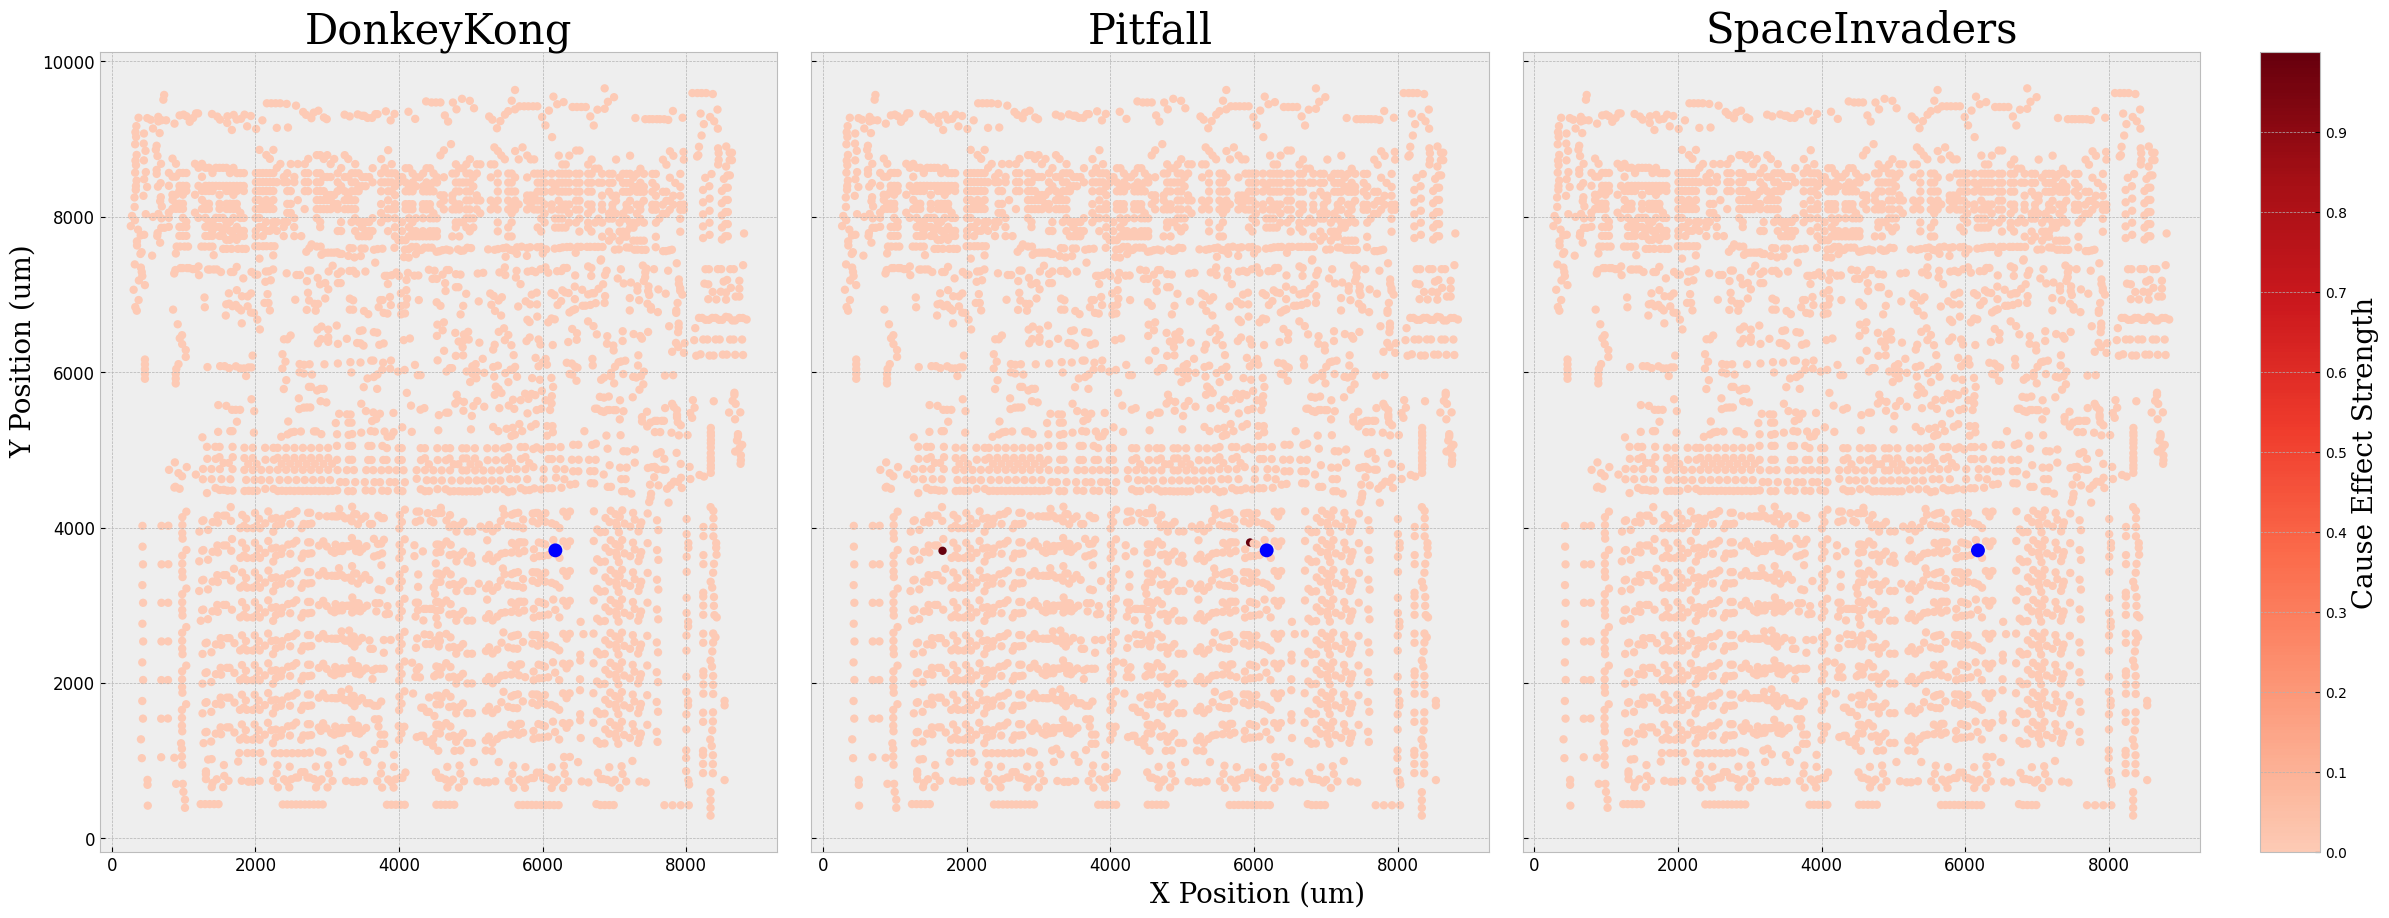

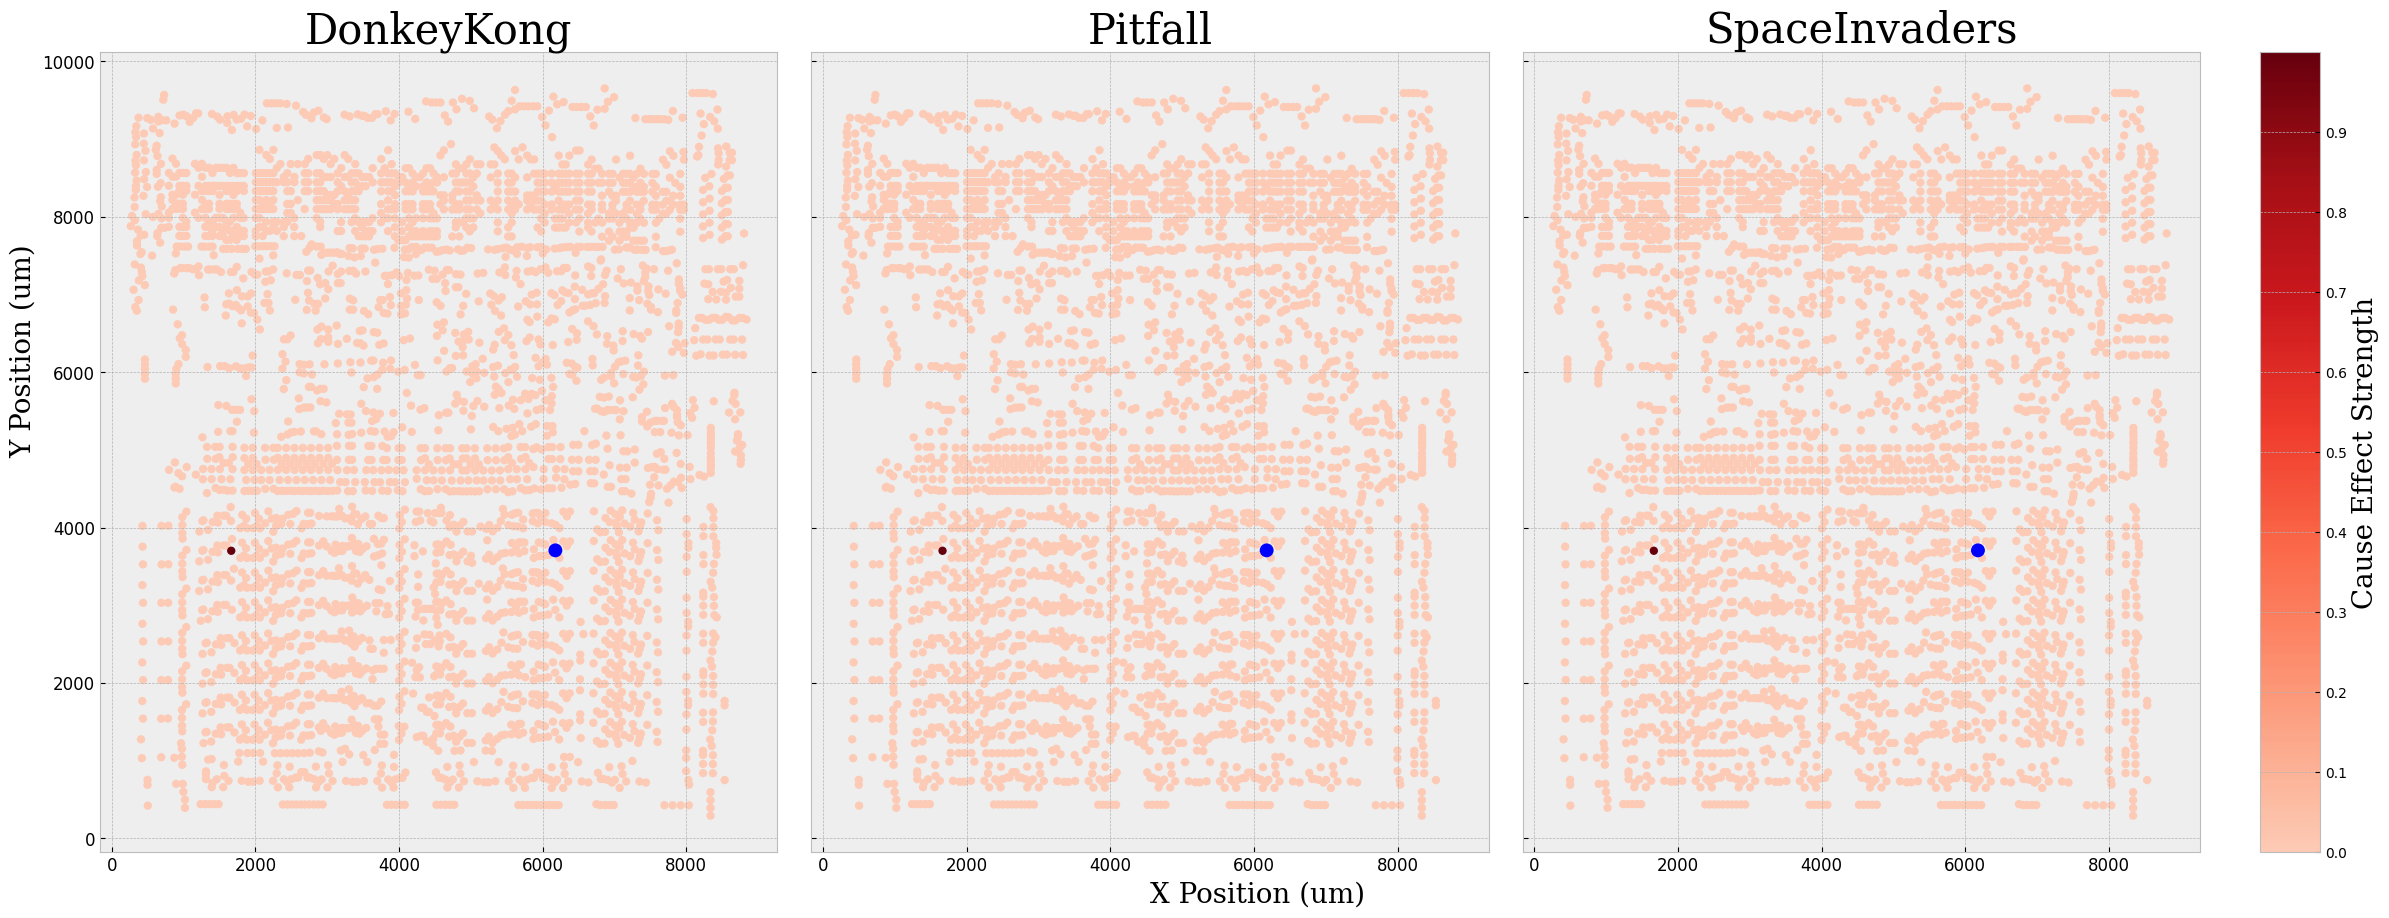

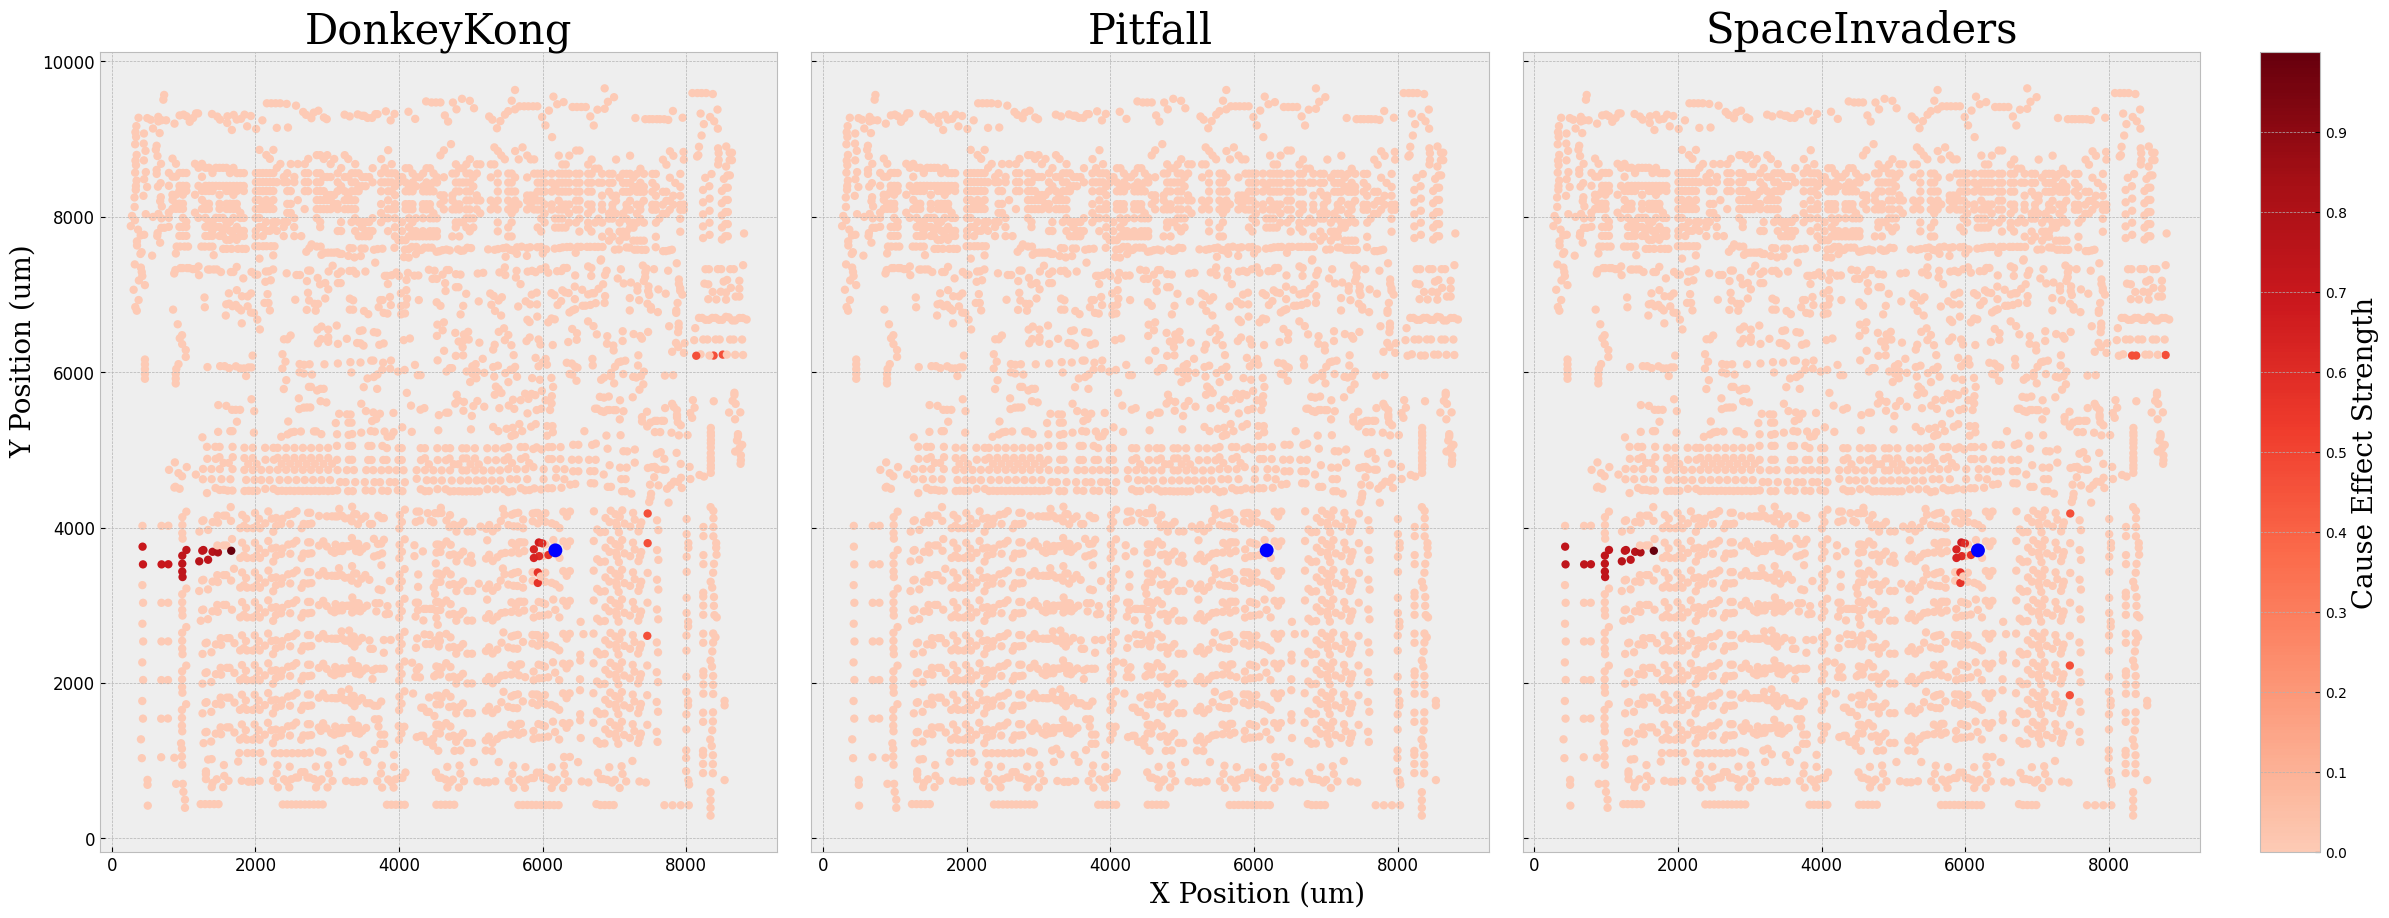

In [37]:
# plot the same transistor in same game for different periods
target_idx = 3355
for window in ['640_768', '768_896', '896_1024']:
    plot_cause_effect(target_idx=target_idx, save_dir=f'/project/lcd_v2/figure/Figure 2. Causal Effect/transistor_{target_idx}_window_{window}')

### Distribution of causal effect strength

In [10]:
from tqdm import tqdm
games = ['DonkeyKong', 'Pitfall', 'SpaceInvaders']
game = games[0]
orig = np.load(os.path.join(root_dir, f'{game}/HR/window_{window}/Regular_3510_step_{num_iterations}_rec_{step_limit}_window_{window}.npy'), mmap_mode='r')
potential_resultant = []
unique_perturb = get_perturb_config(orig)
effects = []
for i in tqdm(unique_perturb):
    effects.append(get_strength({'idx': i, 'game': 'DonkeyKong'}))

  0%|                                                                                                                                                                         | 1/2552 [00:00<08:32,  4.98it/s]

0 (3510, 2) 0.21137108216357317
1 (3510, 2) 0.44013336626507465


  0%|▏                                                                                                                                                                        | 3/2552 [00:00<11:14,  3.78it/s]

2 (3510, 2) 0.4568809849129202


  0%|▎                                                                                                                                                                        | 4/2552 [00:01<12:26,  3.42it/s]

4 (3510, 2) 0.4695306000411475


  0%|▎                                                                                                                                                                        | 5/2552 [00:01<13:11,  3.22it/s]

5 (3510, 2) 0.49233043283939526
6 (3510, 2) 0.36110844016106236


  0%|▍                                                                                                                                                                        | 7/2552 [00:02<14:42,  2.88it/s]

8 (3510, 2) 0.4426279798400982


  0%|▌                                                                                                                                                                        | 8/2552 [00:02<12:42,  3.33it/s]

9 (3510, 2) 0.4999215975857002
10 (3510, 2) 0.1155780685534914


  0%|▋                                                                                                                                                                       | 10/2552 [00:02<10:23,  4.07it/s]

11 (3510, 2) 0.49992614200593427
12 (3510, 2) 0.38821303964357706


  0%|▋                                                                                                                                                                       | 11/2552 [00:03<11:50,  3.57it/s]


FileNotFoundError: [Errno 2] No such file or directory: '.cache/sim_data/DonkeyKong/HR/window_0_128/Perturb_3510_step_128_tidx_13.npy'